### Top Resources: 
- https://deepnote.com/@abid/Trip-Advisor-Data-AnalysisML-9gYLOddsRXmWSKVLyLX_tQ
- https://github.com/Vishwacorp/yelp_nlp
- https://www.kaggle.com/helalehalimohamadi/sentiment-analysis-of-yelp-reviews-nlp#Introduction
- https://nbviewer.org/github/susanli2016/NLP-with-Python/blob/master/EDA%20and%20visualization%20for%20Text%20Data.ipynb
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

### **Importing our libraries**

In [3]:
# Data processing libraries
import pandas as pd
import numpy as np
import re
import string

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud


# NLP Libraries
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Formatting for high resolution images
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Loading in our data**
<hr>

Loading in the data that we pre-processed from Kaggle. We go through a few sanity checks as well such as checking for null values and distilling our data down to only the review text and the corresponding rating so we can easily work with and visualize our NLP analysis.

In [4]:
reviews = pd.read_csv('/content/can_yelp_reviews.csv')
print(reviews.shape)
reviews.head()

(426790, 18)


business_id  ...                 date
0  D4JtQNTI4X3KcbzacDJsMw  ...  2012-08-14 23:07:14
1  D4JtQNTI4X3KcbzacDJsMw  ...  2016-05-19 06:56:54
2  D4JtQNTI4X3KcbzacDJsMw  ...  2015-08-07 13:38:04
3  D4JtQNTI4X3KcbzacDJsMw  ...  2016-09-06 13:17:00
4  D4JtQNTI4X3KcbzacDJsMw  ...  2016-04-12 04:14:38

[5 rows x 18 columns]

In [5]:
reviews.isna().sum()

business_id         0
name                0
address           397
city                0
state               0
postal_code        85
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes       1061
categories          0
hours           26126
user_id             0
review_stars        0
text                0
date                0
dtype: int64

In [6]:
basic_reviews = reviews[['review_stars', 'text']]
basic_reviews.reset_index(drop=True)
print(basic_reviews.shape)
basic_reviews.sample(5)

(426790, 2)


review_stars                                               text
134899             2  Here's the Bottom Line- up front. Go to this p...
171029             5  Hidden gem in the city!   Great patio and frie...
8032               5  Came here for Mother's Day brunch and was very...
34893              4  Good asian fusion\nIf you are looking for good...
46770              4  Haven't been in awhile - but always love it wh...

In [7]:
basic_reviews.head()

review_stars                                               text
0             3  Decent food at reasonable prices. Ambiance is ...
1             4  Good food, and good sized portions for the pri...
2             4  The name of the venue is intriguing but after ...
3             4  Really good Thai food. Had been looking a dece...
4             5  Bookmarked AND the hubby recommended it. Our f...

Before creating any visualizations, let's get a count of how long each review is.

In [8]:
basic_reviews['rev_length'] = basic_reviews['text'].apply(len)
basic_reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



review_stars                                               text  rev_length
0             3  Decent food at reasonable prices. Ambiance is ...          57
1             4  Good food, and good sized portions for the pri...         777
2             4  The name of the venue is intriguing but after ...         686
3             4  Really good Thai food. Had been looking a dece...         238
4             5  Bookmarked AND the hubby recommended it. Our f...        3392

In [9]:
basic_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426790 entries, 0 to 426789
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   review_stars  426790 non-null  int64 
 1   text          426790 non-null  object
 2   rev_length    426790 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.8+ MB


### **Starting our Sentiment Analysis**
<hr>

We're now going to start to pre-process our data and create helpful information that will be useful later on when we dive into some deep learning. We begin with performing sentiment analysis via the VADER library and then using VADER we'll create what's called compound scores. Compound scores are basically our "polarity" scores that tell us if the review is more negative, positive or neutral based on the score it calculates. To convert these scores into useful information, we'll define a function that will assign one of the three categories (positive, negative, or neutral) to each review based on thresholds that we define.

<br>

#### **VADER Sentiment Analysis**
<hr>

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the MIT License (we sincerely appreciate all attributions and readily accept most contributions, but please don't hold us liable). [Vader GitHub](https://github.com/cjhutto/vaderSentiment#introduction)

You can use VADER directly by `pip install`ing `vaderSentiment`. I'm choosing to just download it from the `nltk` library.

In [10]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer() # creating our sentiment analyzer option

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



Here we implement our compound function that uses `.polarity_scores()` from VADER to calculate the sentiment of each review and then we define a function that assigns the sentiment labels based on thresholds and evaluated on the scores previously calculated.

In [12]:
def compound_score(txt):
  return sia.polarity_scores(txt)['compound']

def sentiment(score):
  emotion = ""
  if score >= 0.5:
    emotion = "positive"
  elif score <= -0.5:
    emotion = "negative"
  else:
    emotion = "neutral"
  return emotion

Apply the functions to the data, and create two new columns - one holding our scores, and one collecting the labels.

In [13]:
# apply functions to data

# apply compound score
polarity_scores = basic_reviews['text'].astype("str").apply(compound_score)
basic_reviews["sentiment_score"] = polarity_scores

# apply sentiment
basic_reviews["sentiment"] = basic_reviews["sentiment_score"].apply(sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Save the newly modified data to its own csv file for easier loading and for any other analysis projects we'd want to run on it.

In [14]:
basic_reviews.to_csv("reviews_sentiment.csv", index=False)
basic_reviews.sentiment.value_counts()

positive    344423
neutral      49494
negative     32873
Name: sentiment, dtype: int64

Load the new file in

In [15]:
sentiment_df = pd.read_csv("/content/reviews_sentiment.csv")
sentiment_df.head()

review_stars  ... sentiment
0             3  ...   neutral
1             4  ...  positive
2             4  ...  positive
3             4  ...  positive
4             5  ...  positive

[5 rows x 5 columns]

In [16]:
sentiment_df.isna().sum()

review_stars       0
text               0
rev_length         0
sentiment_score    0
sentiment          0
dtype: int64

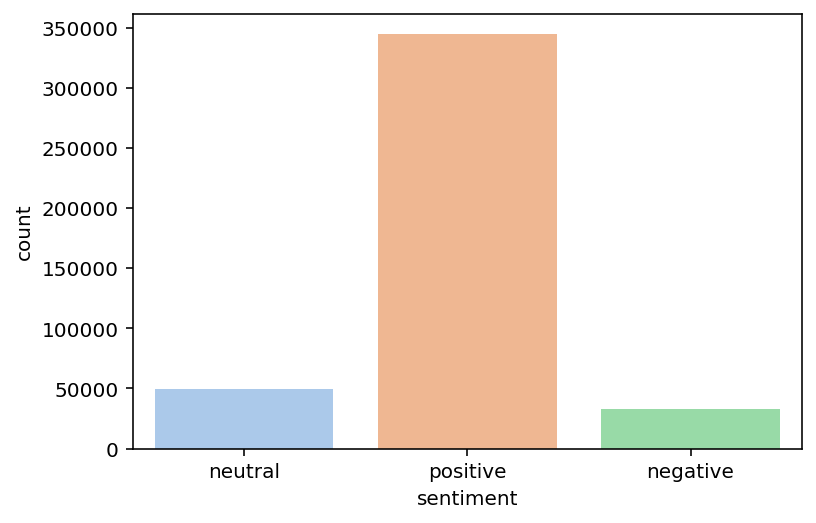

In [17]:
sns.countplot(data=sentiment_df, x='sentiment', palette='pastel');

Peaking at the value counts of our sentimnet categories, we have got a severly imbalanced dataset with the `positive` category being almost 7x the `neutral` category, and nearly 10.5x the `negative` sentiment category.

Let's see the distribution of sentiment within each rating.

In [18]:
sent_ratings = sentiment_df[['review_stars', 'sentiment']].value_counts().reset_index(name='counts')
fig = px.bar(x=sent_ratings.review_stars, y=sent_ratings.counts, color=sent_ratings.sentiment, color_discrete_sequence=px.colors.qualitative.Pastel,
             title='Sentiment & Ratings', labels={'x': 'Ratings', 'y': 'Total Number'})
fig.show()

Surprisingly, we still have a decent amount of "positive" reviews within the 2 star rating and even more so in the 3 star rating. This could be a flaw from when we defined our thresholds in our `sentiment` function with the positive threshold being too low and therefore categorizing some more neutral reviews as positive? We're not quite sure yet, but this could be something to look into if it affects our model later on.

Let's visualize the rating distribution of our data using a pie chart (an easy all-encompassing visual)

In [19]:
# rating distribution of the data
ratings_dist = basic_reviews['review_stars'].value_counts().rename_axis(['ratings']).reset_index(name='counts')

pie = px.pie(values=ratings_dist.counts, names=ratings_dist.ratings, title='Distribution of Ratings', color_discrete_sequence=px.colors.qualitative.Pastel)
pie.show();

In [20]:
# violin plot of ratings and sentiments
fig = go.Figure()

ratings = [1, 2, 3, 4, 5]

for rating in ratings:
  fig.add_trace(go.Violin(x=basic_reviews['review_stars'][basic_reviews['review_stars'] == rating],
                          y=basic_reviews['sentiment_score'][basic_reviews['review_stars'] == rating],
                          name=rating,
                          box_visible=True,
                          meanline_visible=True))
  
fig.update_layout(
    title="Violin plot of Ratings and Sentiment Score with boxplot",
    xaxis_title="Rating",
    yaxis_title="Sentiment Score",
    font=dict(
        family="Courier New, monospace",
        size=12
    )
)
fig.show();

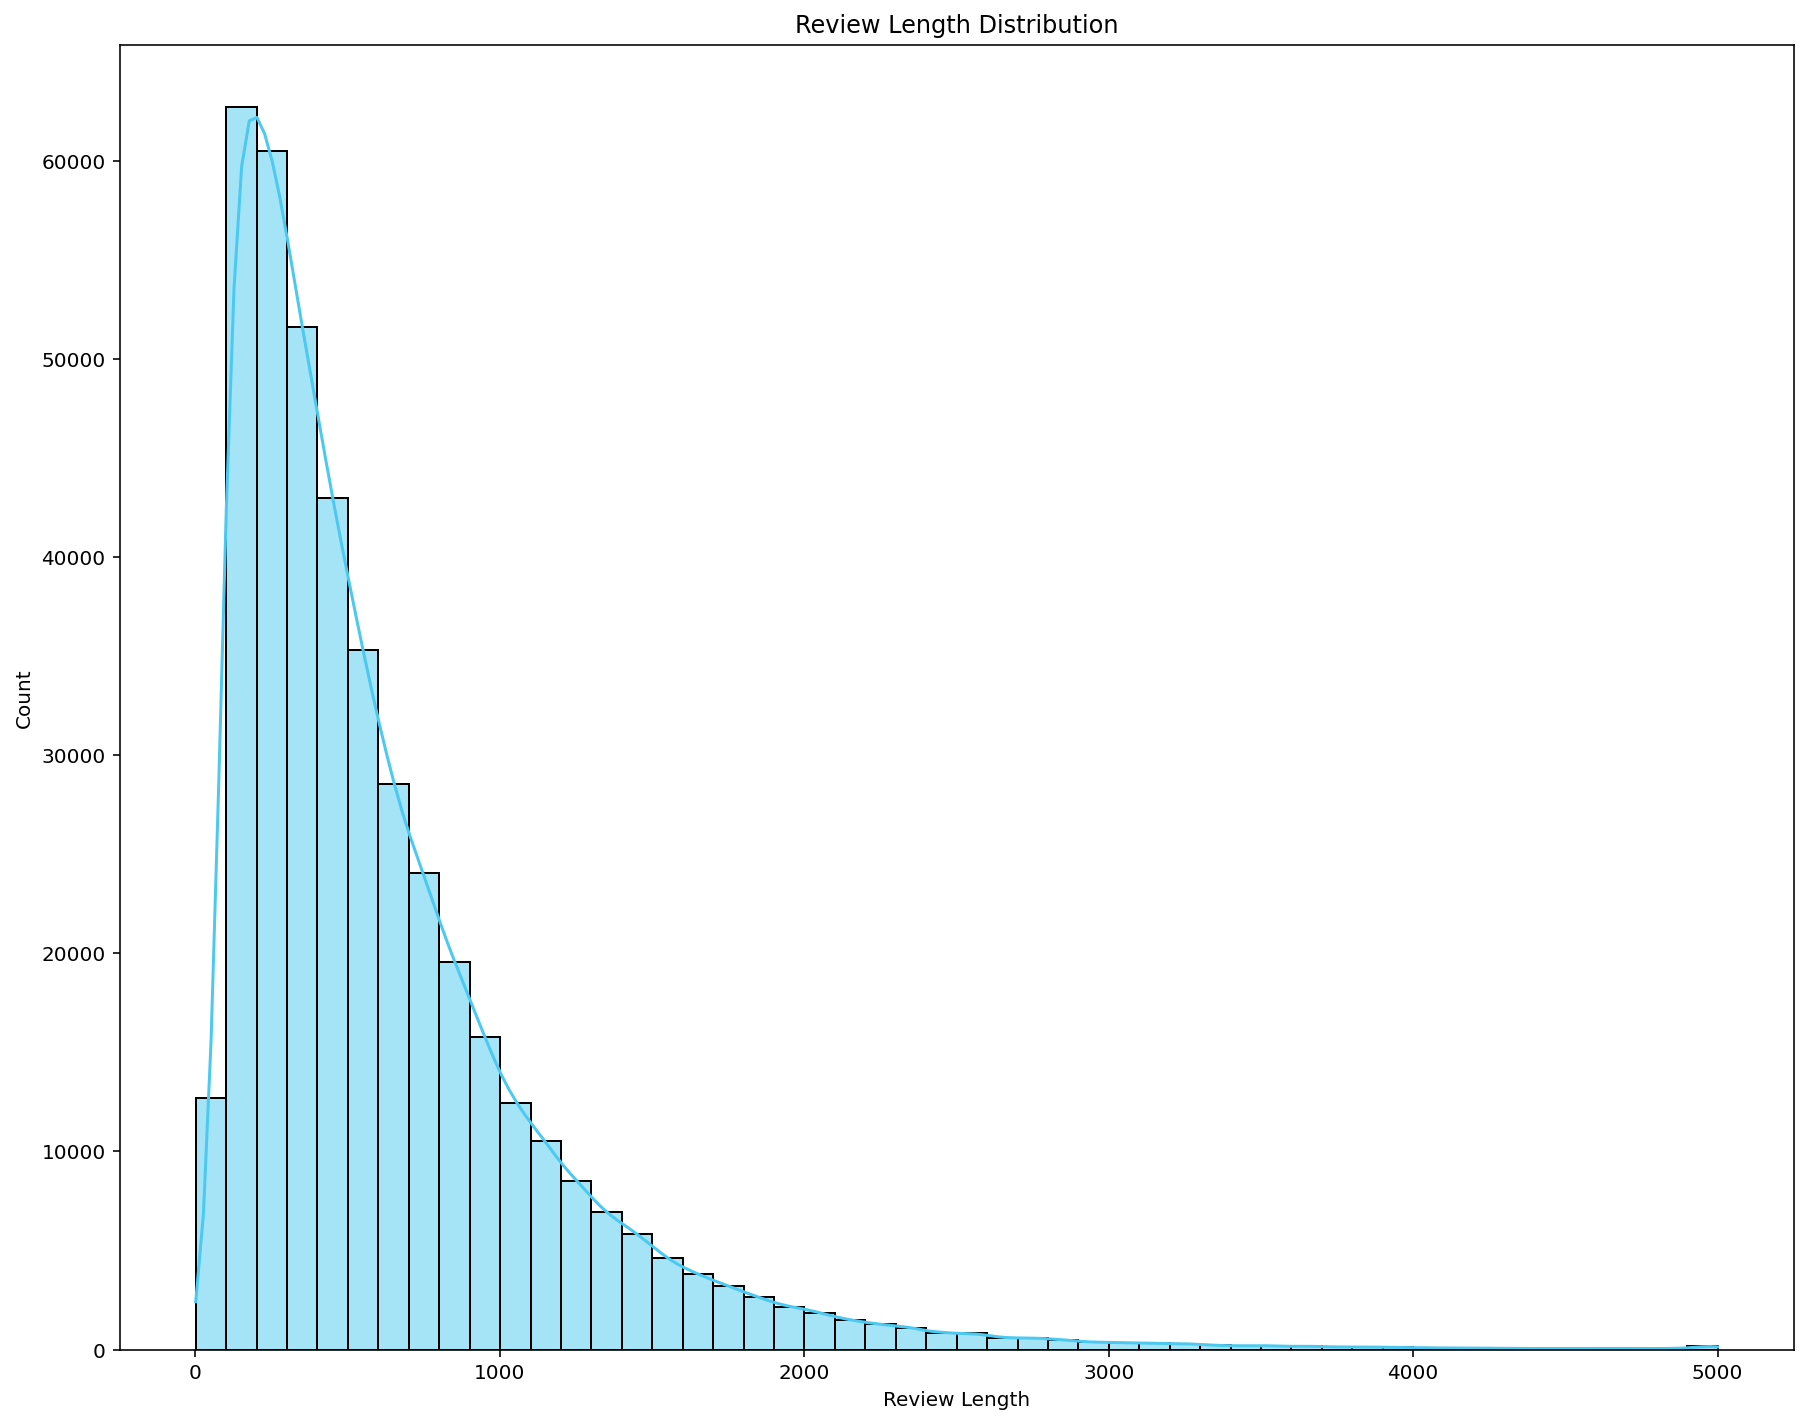

In [21]:
# circling back to visualize review length distribution
plt.figure(figsize=(15, 12))
sns.histplot(data=basic_reviews, x='rev_length', bins=50, kde=True, color="#4cc9f0")
plt.title("Review Length Distribution")
plt.xlabel("Review Length")
plt.show();

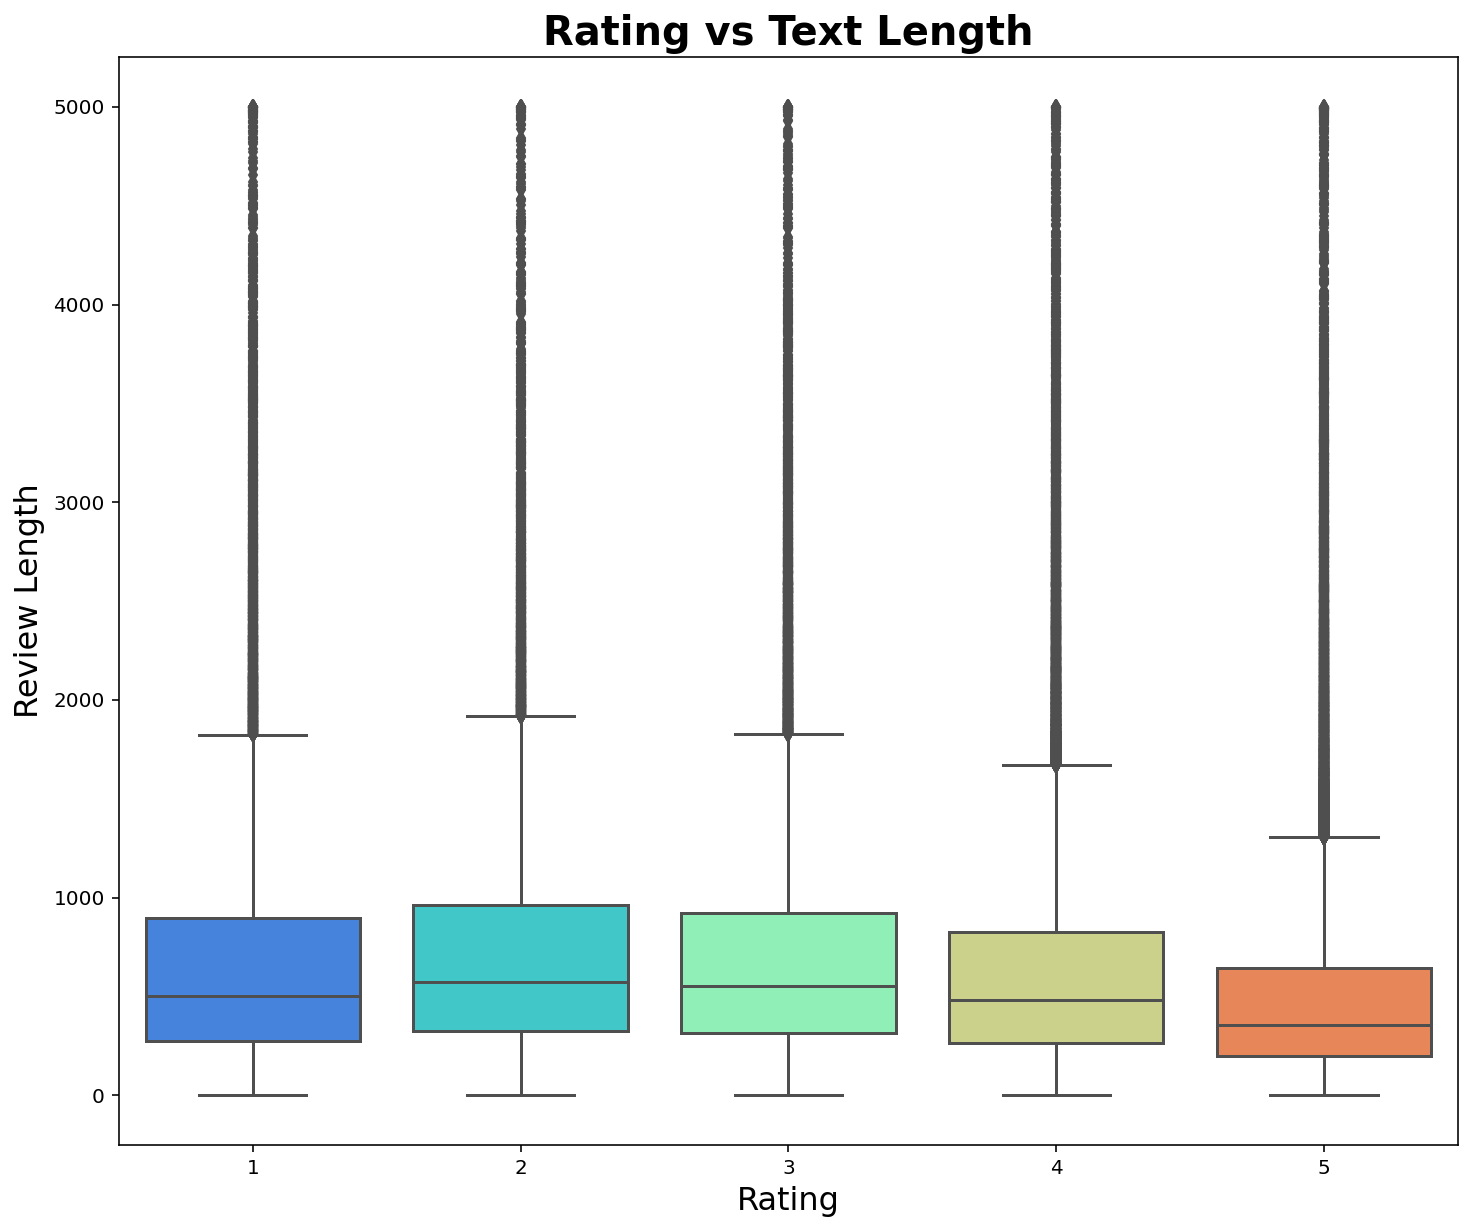

In [22]:
# Text length vs rating
plt.figure(figsize=(12, 10))
sns.boxplot(x='review_stars', y='rev_length', data=basic_reviews, palette='rainbow')
plt.ylabel("Review Length", fontdict={"fontsize": 16})
plt.xlabel("Rating", fontdict={"fontsize": 16})
plt.title("Rating vs Text Length", fontdict={"fontsize": 20, "fontweight": 'bold'})
plt.show();

**Finished with visualizations for now. Moving on to pre-processing for NLP analysis.**

In [23]:
# setting up some functions that will help clean the review text
# so that the data can be fed into models

# the following function is from https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained
def clean_text(text):
  """
  Makes text lowercase, removes text in square brackets (if any),
  removes links (if any), removes punctuation, removes words containing
  numbers (if any), and removes stopwords.
  """
  stop_words = stopwords.words('english')

  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)

  return text

basic_reviews['cleaned_text'] = basic_reviews['text'].apply(clean_text)
basic_reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



review_stars  ...                                       cleaned_text
0             3  ...  decent food reasonable prices ambiance odd though
1             4  ...  good food good sized portions price enjoyed di...
2             4  ...  name venue intriguing dinner bob likes thai fo...
3             4  ...  really good thai food looking decent place mou...
4             5  ...  bookmarked hubby recommended first time also b...

[5 rows x 6 columns]

In [24]:
basic_reviews['clean_length'] = basic_reviews['cleaned_text'].apply(len)
basic_reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



review_stars  ... clean_length
0             3  ...           49
1             4  ...          489
2             4  ...          414
3             4  ...          164
4             5  ...         2158

[5 rows x 7 columns]

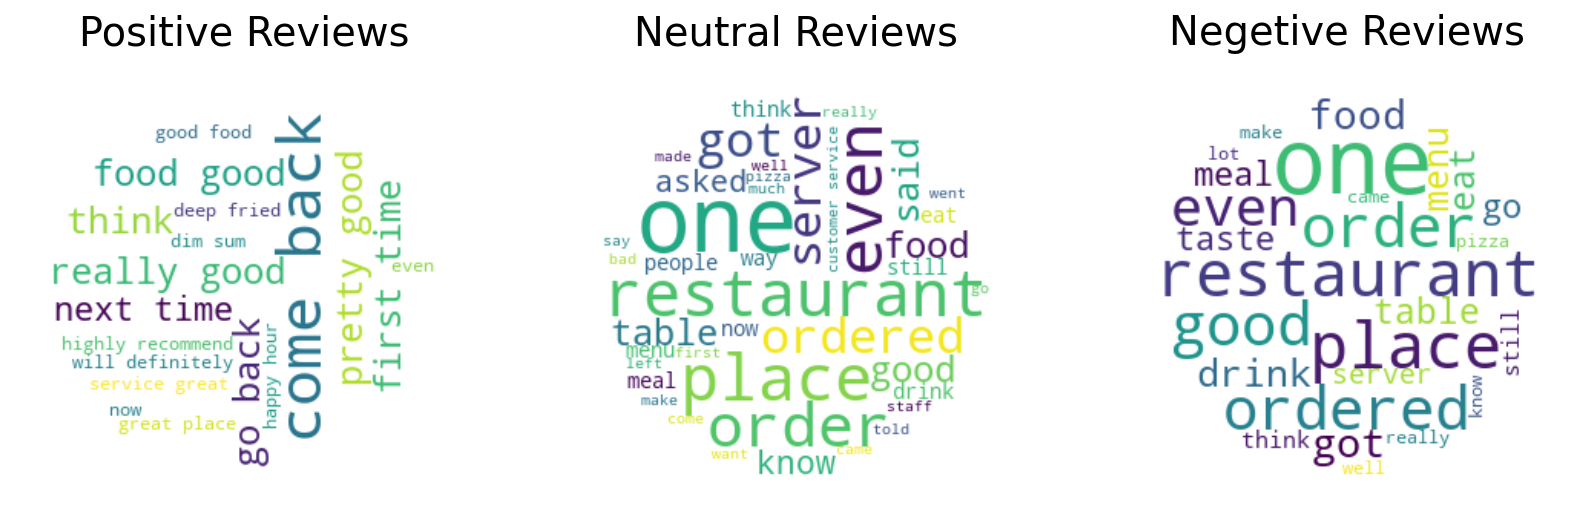

In [25]:
# wordcloud for all sentiment categories

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 14], facecolor = None)

text1 =''
for i in basic_reviews[basic_reviews['sentiment']=='positive']['text'].values:
    text1+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(text1)

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Positive Reviews',fontsize=20);

text2 =''
for i in basic_reviews[basic_reviews['sentiment']=='negative']['text'].values:
    text2+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(text2)

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Neutral Reviews',fontsize=20);

text3 =''
for i in basic_reviews[basic_reviews['sentiment']=='neutral']['text'].values:
    text3+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(text3)

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title('Negetive Reviews',fontsize=20);

plt.show();

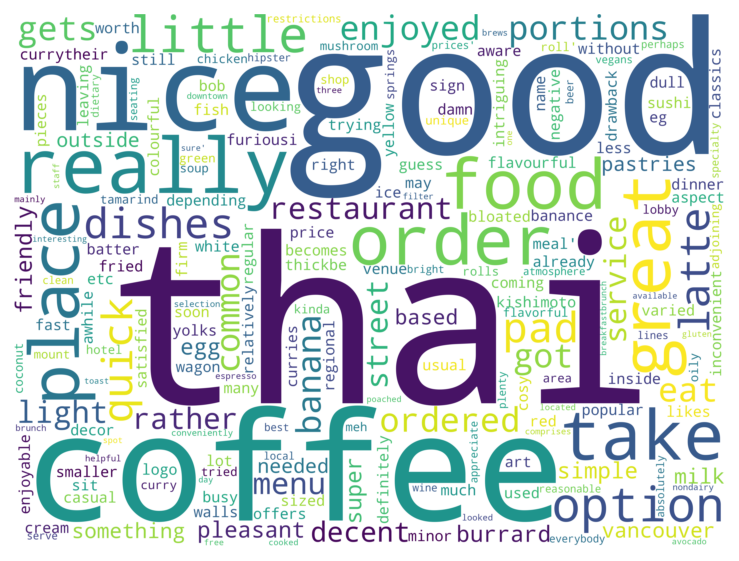

In [26]:
positive_review_words = basic_reviews[basic_reviews['sentiment'] == 'positive']['cleaned_text'].values

word_cloud = WordCloud(width=4000, height=3000, background_color="white").generate(str(positive_review_words))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()

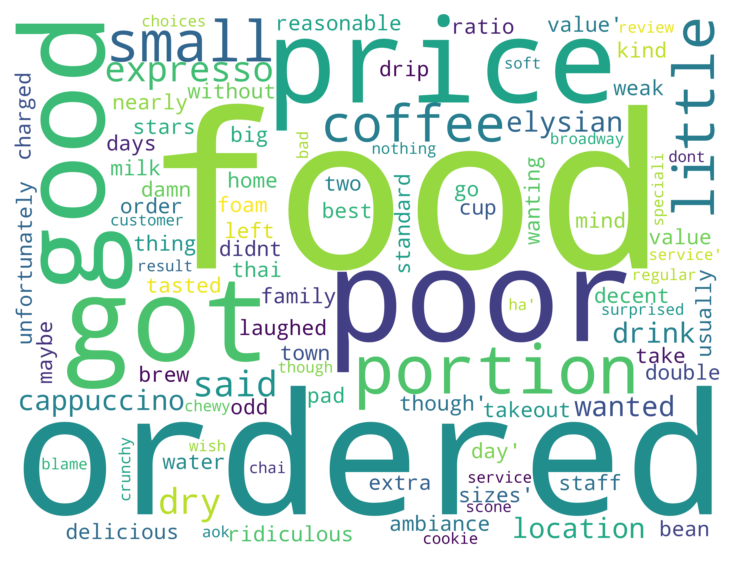

In [27]:
neutral_review_words = basic_reviews[basic_reviews['sentiment'] == 'neutral']['cleaned_text'].values

word_cloud = WordCloud(width=4000, height=3000, background_color="white").generate(str(neutral_review_words))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()

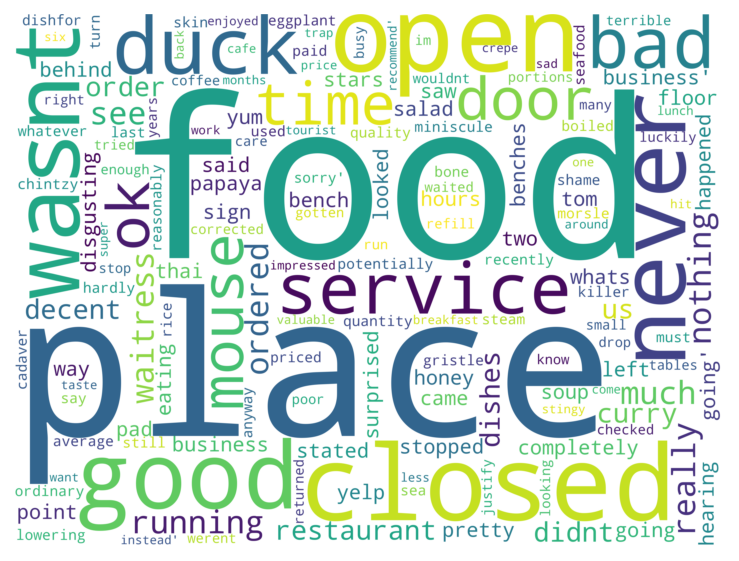

In [28]:
negative_review_words = basic_reviews[basic_reviews['sentiment'] == 'negative']['cleaned_text'].values

word_cloud = WordCloud(width=4000, height=3000, background_color="white").generate(str(negative_review_words))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
from plotly.offline import iplot

In [31]:
# n-gram visualizations

def get_ngrams(corpus, n=None):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bow = vec.transform(corpus)
  sum_words = bow.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_ngrams(basic_reviews['cleaned_text'], 20)
for word, freq in common_words:
  print(word, freq)

unigram_df = pd.DataFrame(common_words, columns=['text', 'count'])

food 306293
good 267129
place 239900
like 166317
service 166111
great 161086
really 130155
time 125138
restaurant 115982
ordered 107162
chicken 97641
came 90465
order 89317
nice 83857
menu 83527
dont 81907
try 78915
delicious 78825
got 77539
best 73283


In [32]:
fig = px.bar(
    unigram_df,
    'text',
    'count',
    title="Top 20 unigrams"
)

fig.update_layout(
    xaxis_title="Text",
    yaxis_title="Count"
)

fig.show()

In [33]:
def get_bigrams(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
  bow = vec.transform(corpus)
  sum_words = bow.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_bigrams(basic_reviews['cleaned_text'], 20)
for word, freq in common_words:
  print(word, freq)

bigram_df = pd.DataFrame(common_words, columns=['text', 'count'])

come back 23316
go back 18633
really good 17161
pretty good 16553
first time 15974
food good 13592
next time 12556
dim sum 12515
highly recommend 11248
customer service 10372
good food 10270
ive ever 10107
even though 9900
ice cream 9320
great food 9259
happy hour 9197
deep fried 9149
great place 9070
one best 9041
great service 8990


In [34]:
fig = px.bar(
    bigram_df,
    'text',
    'count',
    title="Top 20 Bigrams"
)

fig.update_layout(
    xaxis_title="Text",
    yaxis_title="Count"
)

fig.show()

In [35]:
def get_trigrams(corpus, n=None):
  vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
  bow = vec.transform(corpus)
  sum_words = bow.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_trigrams(basic_reviews['cleaned_text'], 20)
for word, freq in common_words:
  print(word, freq)

trigram_df = pd.DataFrame(common_words, columns=['text', 'count'])

definitely come back 4377
would come back 3285
come back try 2932
would go back 2562
definitely go back 2478
would definitely come 2209
cant go wrong 2141
would definitely recommend 1964
would highly recommend 1824
go back try 1756
food great service 1637
definitely coming back 1604
food good service 1586
food pretty good 1565
highly recommend place 1513
best ive ever 1487
wait go back 1472
seated right away 1462
beef noodle soup 1447
next time im 1419


In [36]:
fig = px.bar(
    trigram_df,
    'text',
    'count',
    title="Top 20 Trigrams"
)

fig.update_layout(
    xaxis_title="Text",
    yaxis_title="Count"
)

fig.show()

**Topic Modeling of Review Text**
- generate document-term matrix from review text with TF-IDF
- LSA model replaces raw counts in the document-term matrix with a TF-IDF
- perform dimensionality reduction on the document-term matrix using TruncatedSVD
- set a somewhat arbitrary number of topics (we'll choose 5 based on the fact that there are 5 stars in the ratings category)
- taking the argmax of each review text in the topic matrix will give the predicted topics of each review in the data. We can then sort these into counts of each topic
- to better understand each topic, we'll find the top n most frequent words in each topic

In [37]:
from sklearn.decomposition import TruncatedSVD
from collections import Counter

In [38]:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

data = basic_reviews['text']
tf_idf_vec = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
data = data.values
doc_term_matrix = tf_idf_vec.fit_transform(data)
n_topics = 5
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(doc_term_matrix)

def get_keys(topic_matrix):
  """
  Returns an integer list of predicted topic
  categories for a given topic matrix
  """
  keys = topic_matrix.argmax(axis=1).tolist()
  return keys

def keys_to_count(keys):
  """
  Returns a tuple of topic categories and their
  corresponding magnitudes for a given list of keys
  """
  count_pairs = Counter(keys).items()
  categories = [pair[0] for pair in count_pairs]
  counts = [pair[1] for pair in count_pairs]
  return (categories, counts)

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_count(lsa_keys)

def get_top_n_words(n, keys, doc_term_matrix, tf_idf_vec):
  """
  Returns a list of n_topics, where each string contains the
  n most frequent words in a predicted category in order
  """
  top_word_indices = []
  for topic in range(n_topics):
    temp_vec_sum = 0
    for i in range(len(keys)):
      if keys[i] == topic:
        temp_vec_sum += doc_term_matrix[i]
    temp_vec_sum = temp_vec_sum.toarray()
    top_n_word_indices = np.flip(np.argsort(temp_vec_sum)[0][-n:], 0)
    top_word_indices.append(top_n_word_indices)
  top_words = []
  for topic in top_word_indices:
    topic_words = []
    for index in topic:
      temp_word_vec = np.zeros((1, doc_term_matrix.shape[1]))
      temp_word_vec[:, index] = 1
      the_word = tf_idf_vec.inverse_transform(temp_word_vec)[0][0]
      topic_words.append(the_word.encode('ascii').decode('utf-8'))
    top_words.append(" ".join(topic_words))
  return top_words

top_n_words_lsa = get_top_n_words(3, lsa_keys, doc_term_matrix, tf_idf_vec)

for i in range(len(top_n_words_lsa)):
  print("Topic {}:".format(i + 1), top_n_words_lsa[i])

Topic 1: food good place
Topic 2: great food service
Topic 3: sushi roll rolls
Topic 4: ramen broth chicken
Topic 5: pizza crust pizzas
